# Cosmic measurements with 200 cm scintillator
triggers are cosmic events
last edit Dec-17 2020 (EOC)


In [1]:
import sys; sys.path.insert(0, '/Users/erezcohen/Desktop/PETsys/Software/PETsysAnalysis/Python'); 
from PETsys_analysis_tools import *;
from scipy.optimize import curve_fit
main_figures_path = '/Users/erezcohen/Desktop/PETsys/write-ups/DuSci/Figures/'
%config InlineBackend.figure_format = 'retina'

In [2]:
dT = 450 # sec
v_th_e = 6
data_path = '/Users/erezcohen/Desktop/data/PETsys/DuSi/TAU_200cm_scintillator_Dec16_2020/'
coinc_data = pd.read_csv(data_path+'cosmic_vth_e_%d_%dsec_coinc.dat'%(v_th_e,dT),                                                          
                             delimiter='\t',
                             names=['mh_n1','mh_j1','time1','e1','id1','mh_n2','mh_j2','time2','e2','id2'])
print 'done loading data.'
coinc_data[99:130]

done loading data.


,mh_n1,mh_j1,time1,e1,id1,mh_n2,mh_j2,time2,e2,id2
99,6,0,702767937166,33.940228,920,1,0,702767943764,21.564209,76
100,6,1,702767939659,24.886707,902,1,0,702767943764,21.564209,76
101,6,2,702767954253,19.013737,929,1,0,702767943764,21.564209,76
102,6,3,702767934340,18.316349,911,1,0,702767943764,21.564209,76
103,6,4,702767933772,16.717560,954,1,0,702767943764,21.564209,76
104,6,5,702767957844,5.931549,938,1,0,702767943764,21.564209,76
105,13,0,746217639422,32.114006,900,2,0,746217630733,29.334515,107
106,13,0,746217639422,32.114006,900,2,1,746217630896,17.298126,74
107,13,1,746217629004,30.256588,909,2,0,746217630733,29.334515,107
108,13,2,746217624240,26.209538,907,2,0,746217630733,29.334515,107


In [3]:
def init_event(mh_n1,mh_n2,i,eventId,fdebug=0):#{
    t_R,t_L,summed_Q = [],[],[]
    i_line_in_event = 0;
    N_R,N_L = mh_n1[i+1], mh_n2[i+1];
    N_lines_in_event = N_R+N_L-1
    if fdebug>0:
        print '-------------------------------------------------'
        print 'initializing event',eventId
        print N_lines_in_event,'lines in event ',eventId,': %d->%d'%(i+1,i+1+N_lines_in_event-1)
        print '-------------------------------------------------'

    return t_R,t_L,summed_Q,N_R,N_L,i_line_in_event
#}

In [4]:
fdebug = 0
Nmax = len(coinc_data)
print 'processing',Nmax,'lines of coincidence file'

mh_n1,mh_n2 = np.array(coinc_data['mh_n1']), np.array(coinc_data['mh_n2'])
time1,time2 = np.array(coinc_data['time1']), np.array(coinc_data['time2'])
e1,e2 = np.array(coinc_data['e1']),np.array(coinc_data['e2'])    
    
Events = pd.DataFrame()    

i, eventId = 0,0;
t_R,t_L,summed_Q,N_R,N_L,i_line_in_event = init_event(mh_n1,mh_n2,i,eventId,fdebug)

for i in np.arange(Nmax)-1:#{
    
    N_lines_in_event = mh_n1[i] + mh_n2[i] - 1
    t_R.append(time1[i])
    t_L.append(time2[i])
    summed_Q.append(e1[i]+e2[i])    
    i_line_in_event = i_line_in_event + 1
    
    
    if fdebug>1: 
        print 'i:',i,',n(R): %d, n(L): %d'%(mh_n1[i],mh_n2[i]),
        print ',t(R): %.1f ns,t(L): %.1f ns, dt=%.1f ns'%(time1[i]/1e3,time2[i]/1e3,(time1[i]-time2[i])/1e3),
        print ',event line:',i_line_in_event, '/',N_lines_in_event

            
    if i_line_in_event > N_lines_in_event-1:#{
        # (1) summarize this event
        # keep only unique values of t_L and t_R and sort them by time
        dt_all = get_all_differences_R_L(np.unique(t_L),np.unique(t_R));
        Events = Events.append(pd.DataFrame({   'Qtotal':np.sum(summed_Q),
                                                'Qavg':np.sum(summed_Q)/(len(summed_Q)),
                                                'mean_dt_all':np.mean(dt_all),
                                                }, 
                                                index=[eventId]), 
                                                ignore_index=True)
        
        if fdebug>0: #{
            print '-------------------------------------------------'
            print 'done event',(eventId)
            print dt_all.T
            print 'mean dt: %.2f'%(np.mean(dt_all)/1e3),'ns'
            print 'xxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxx'
        #}
        # (2) initialize next event
        eventId = eventId+1
        t_R,t_L,summed_Q,N_R,N_L,i_line_in_event = init_event(mh_n1,mh_n2,i,eventId,fdebug)
    #}           
    if i%10000==0:  print '%.1f'%(100.*float(i)/Nmax),'%'
#}
print 'done. processed %d lines and collected %d events'%(Nmax,len(Events))
print 'Events:'
Events[0:10]

processing 184928 lines of coincidence file
0.0 %
5.4 %
10.8 %
16.2 %
21.6 %
27.0 %
32.4 %
37.9 %
43.3 %
48.7 %
54.1 %
59.5 %
64.9 %
70.3 %
75.7 %
81.1 %
86.5 %
91.9 %
97.3 %
done. processed 184928 lines and collected 21011 events
Events:


,Qavg,Qtotal,mean_dt_all
0,60.686030,6007.916940,1.142265e+12
1,43.292628,259.755765,-1.990794e+10
2,50.861704,712.063855,-1.114094e+10
3,42.413405,424.134049,-1.515527e+10
4,39.539916,553.558823,-2.546547e+08
5,45.130049,1037.991118,-1.399543e+10
6,46.557297,139.671890,8.090733e+09
7,52.086333,104.172665,2.138000e+03
8,47.955956,479.559561,-2.530884e+08
9,47.249900,377.999199,-1.953048e+08


# time charecteristics

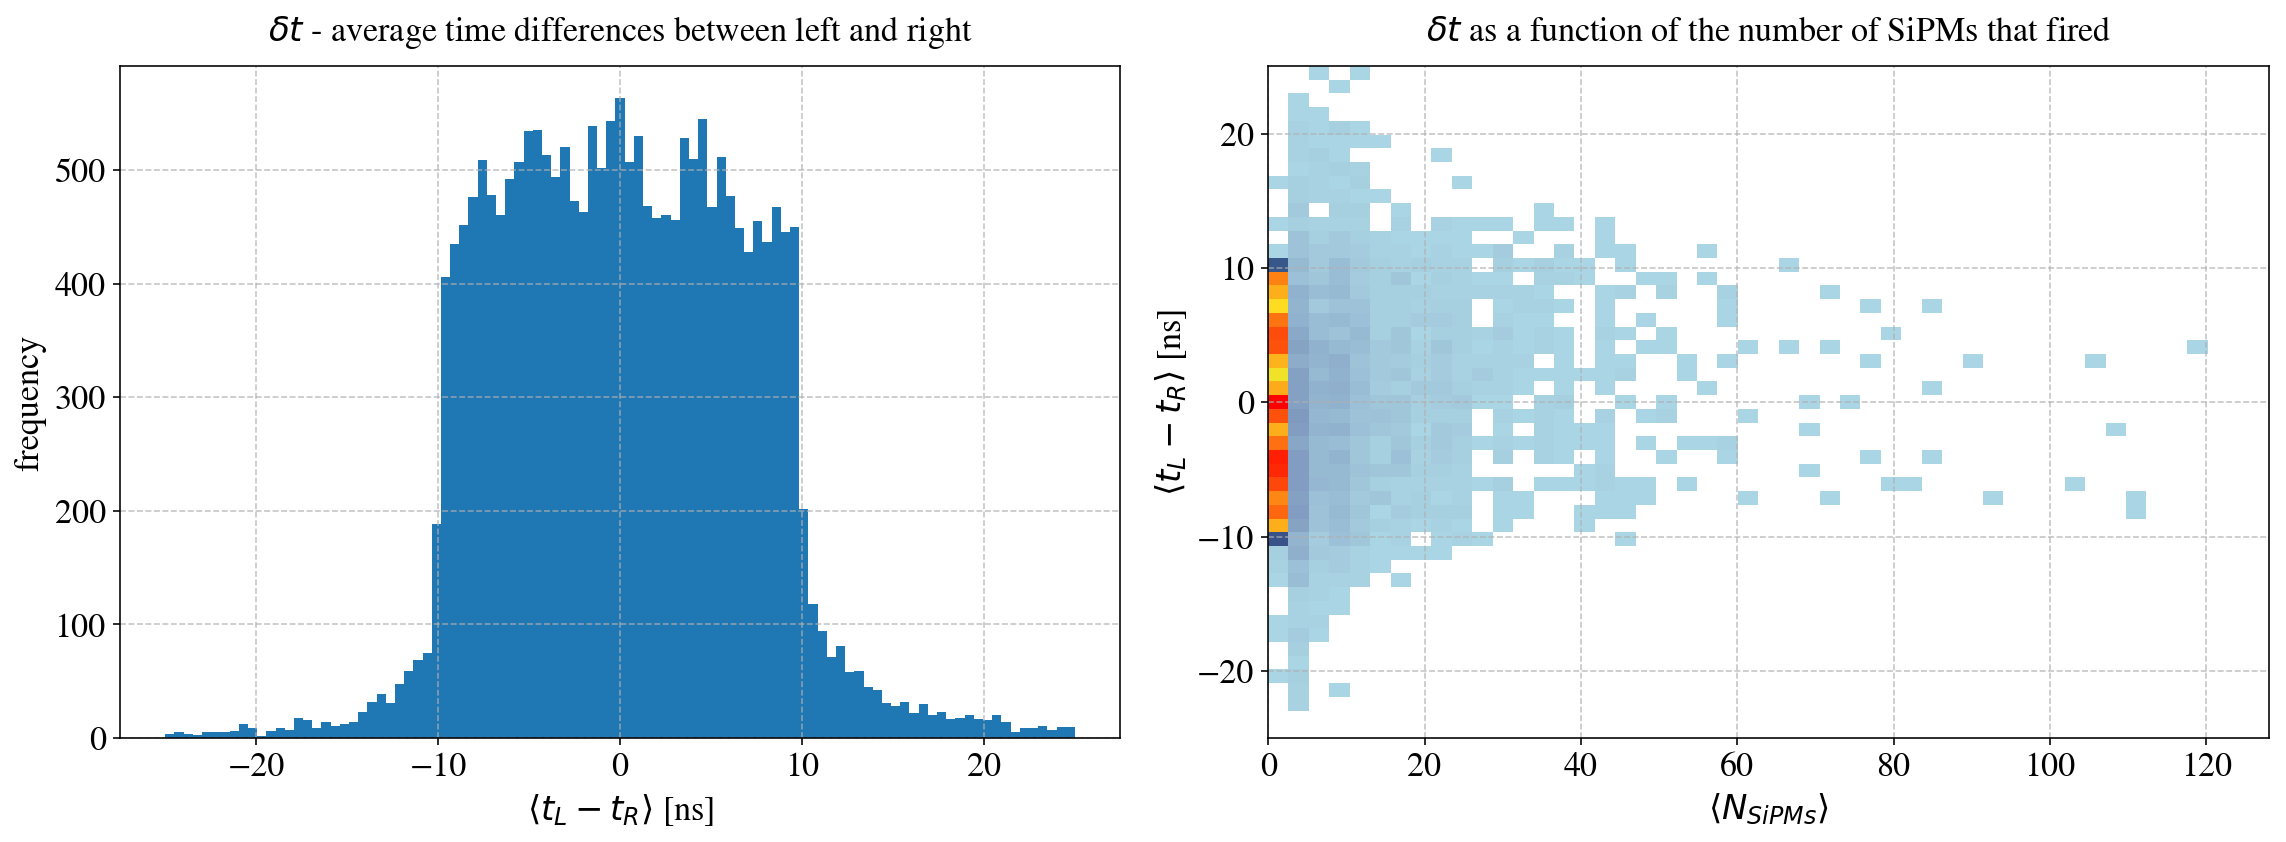

In [9]:
fig=plt.figure(figsize=(16,6));
ax=fig.add_subplot(1,2,1)
mean_dt_ns = Events.mean_dt_all/1e3
plt.hist(mean_dt_ns,bins=np.linspace(-25,25,100));

# cosmetics
set_axes(ax=ax,x_label='$\\left<t_{L} - t_{R}\\right>$ [ns]',
         y_label='frequency',                      
         title='$\delta t$ - average time differences between left and right',         
         fontsize=17,do_add_grid=True,do_add_legend=False);

ax=fig.add_subplot(1,2,2, projection='scatter_density')
Events["NSiPMs"] = Events.Qtotal/Events.Qavg
# ax.scatter(NSiPMs,mean_dt_ns);
ax.hist2d(NSiPMs,mean_dt_ns,bins=(np.linspace(0,128,50),np.linspace(-25,25,50)),cmap=white_viridis);
# ax.scatter_density(NSiPMs,mean_dt_ns,cmap=white_viridis, dpi=8, downres_factor=20)

# cosmetics
set_axes(ax=ax,x_label='$\\left<N_{SiPMs}\\right>$',         
         y_label='$\\left<t_{L} - t_{R}\\right>$ [ns]',
         title='$\delta t$ as a function of the number of SiPMs that fired',         
         fontsize=17,do_add_grid=True,do_add_legend=False);


plt.tight_layout()

# error-function time-resolution fit:
$$ p(\Delta t) = 
\frac{\sqrt\pi}{2\mathbb{N}}
\left(
erf\left( \frac{\Delta t + d/v}{2\sqrt{\left<t_R^2\right>}}\right)
- erf\left( \frac{\Delta t - d/v}{2\sqrt{\left<t_L^2\right>}}\right)
\right) $$

where $\mathbb{N}$ is a normalisation factor,

$d=2$ m is the length of the scintillator,

$v=0.01543 \pm 0.00002$ cm/ps is the speed of the light inside the scintillator

and $\sigma = \sqrt{2 \left<t_L^2\right> } = \sqrt{2 \left<t_L^2\right>}$

so

$$ p(\Delta t) = 
N
\left(
erf\left( \frac{\Delta t + t_0}{\sqrt2 \sigma}\right)
- erf\left( \frac{\Delta t - t_0}{\sqrt2 \sigma}\right)
\right) $$

where $t_0 = d/v = 0.12961$ ns 

In [6]:
def time_difference_L_R(dt, sigma, t0=0.12961, N=0.8862):
    # input:
    # dt in [ns]
    # 
    # fit parameters: :
    # sigma in [ns]
    # N normalisation factor 
    #           for a normalised distribution N = sqrt(pi)/2 = 0.8862
    # t0 = d/v = 0.12961
    from scipy.special import erf
    print "N=",N,'sigma=',sigma,'t0=',t0
    return N * ( erf((dt+t0)/(1.414*sigma)) - erf((dt-t0)/(1.414*sigma)) ) 

N= 0.023 sigma= 0.3 t0= 10.0
N= 0.023 sigma= 0.3 t0= 10.0
N= 0.023 sigma= 0.3 t0= 10.0
N= 0.023 sigma= 0.303 t0= 10.0
N= 0.023 sigma= 0.3 t0= 10.1
N= 0.02323 sigma= 0.3 t0= 10.0
N= 0.023 sigma= 0.3 t0= 10.0


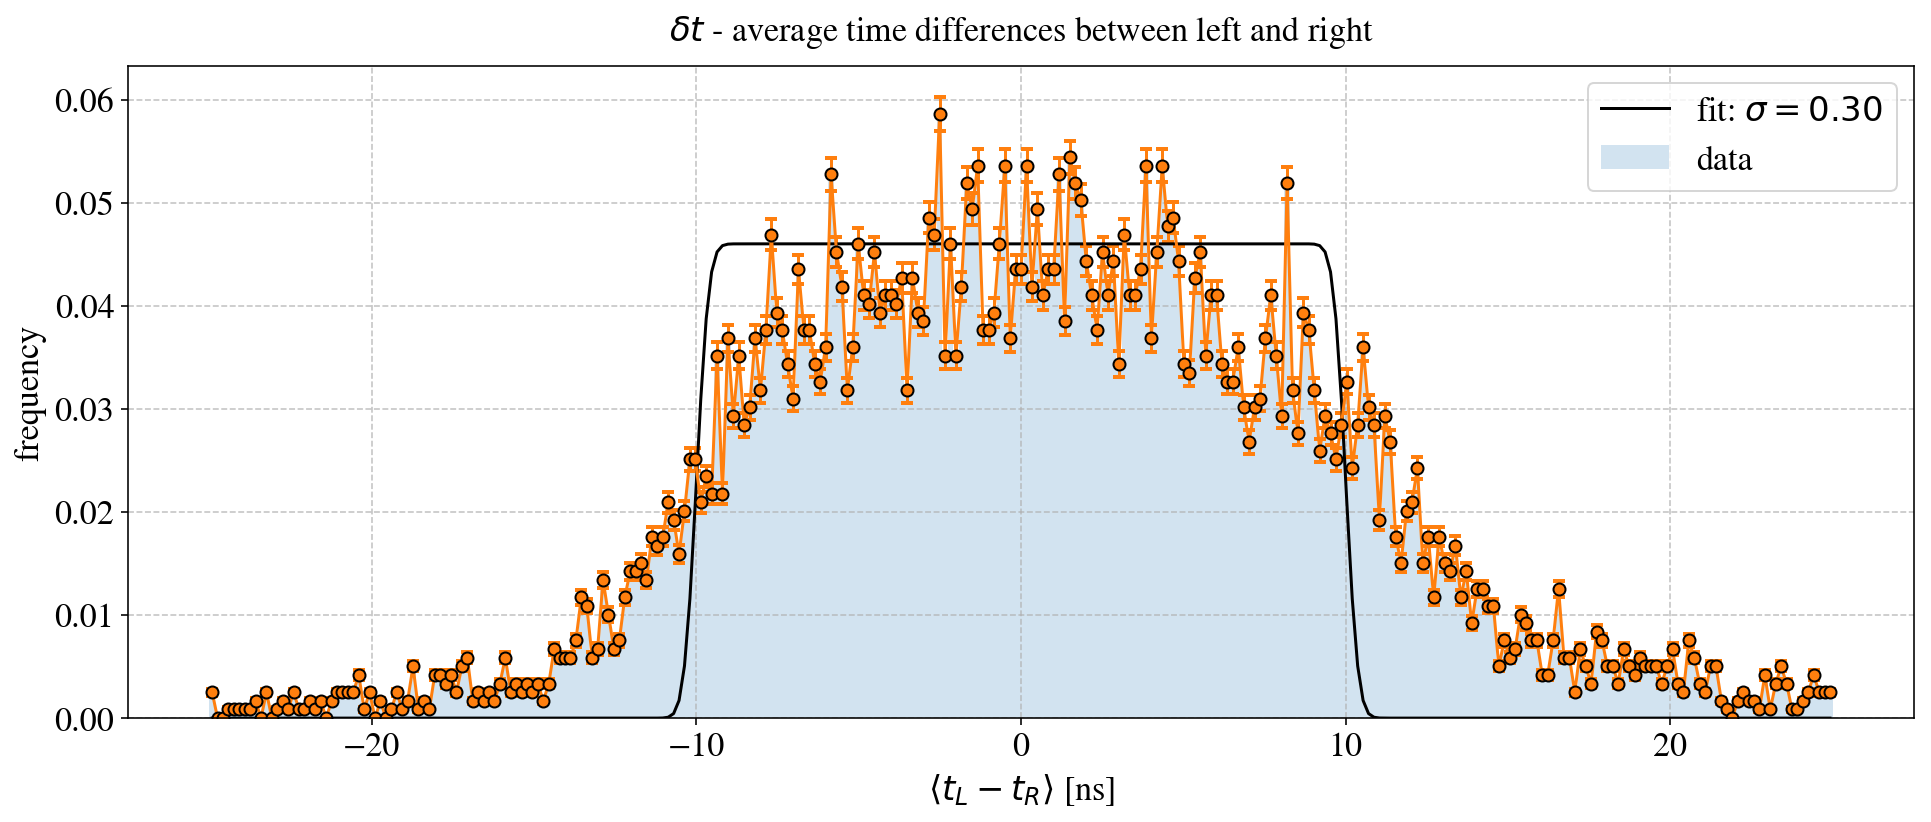

In [15]:
goodEvents = Events[Events["NSiPMs"]>2]
mean_dt_ns = goodEvents.mean_dt_all/1e3 # [ns]

bins=np.linspace(-25,25,300)

fig=plt.figure(figsize=(16,6));
ax=fig.add_subplot(1,1,1)

y,edges,patches = plt.hist(mean_dt_ns,bins=bins,normed=1,alpha=0.2,label='data');

dt = (edges[1:] + edges[0:-1])/2
width = (edges[1:] - edges[0:-1])
yerr = np.sqrt(y*len(Events))/len(Events)
plt.errorbar(dt,y,yerr,marker='o',capthick=2,capsize=3,markeredgecolor='k');

dt_fit = np.linspace(np.min(bins),np.max(bins),1000)
# plt.plot(dt_fit, time_difference_L_R(dt_fit, 0.1, 10., 0.023), 'k-')

# fit
popt, pcov = curve_fit( time_difference_L_R, dt, y, p0=[0.3, 10., 0.023], sigma=yerr, 
                       method='lm',epsfcn=1e-4)
plt.plot(dt, time_difference_L_R(dt, *popt), 'k-', 
         label='fit: $\sigma=%.2f$' % popt[0])

# cosmetics
set_axes(ax=ax,x_label='$\\left<t_{L} - t_{R}\\right>$ [ns]',
         y_label='frequency',                      
         title='$\delta t$ - average time differences between left and right',         
         fontsize=17,do_add_grid=True,do_add_legend=True);

In [174]:
pcov

array([[inf, inf, inf],
       [inf, inf, inf],
       [inf, inf, inf]])